# Do / To Do

In [1]:
# 2022-12-21
## Do - 오전 : 데이터탐색 리뷰, 프로젝트 주제 타당성 검토, 데이터 및 기술타당성 검토, 계획서 작성 및 제출
## Do - 오후 : 딥러닝 모델 준비 - OutPut이 2종류인 이미지 분류 Sequential 모델 작성 (중)
## To Do : 딥러닝 Sequential 모델 완성 / CNN 모델 추가 / 객체탐지 attatch / Mobile - Code 간 연동

# 2022-12-22
## Do - 오전 : 이미지 리사이징 기술 탐색
## Do - 오후 : 다중 출력 딥러닝 모델 (Dense) 완성
## To Do : 다중출력모델 - CNN 모델 추가 / 테스트 데이터 크롤링 / 객체탐지 attatch / Mobile - Code 간 연동

# 배움

In [2]:
# softmax : 모든 변수 확률값의 합이 1
# sigmoid : 0 ~ 1 사이 값을 가짐??

In [3]:
# loss 함수
## spares_..._crossentropy : 원 핫 인코딩에 대한 로스
## ..._crossentropy : 레이블 인코딩에 대한 로스

# 사전 준비 (Import, Mount)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob as glob
import cv2


In [2]:
# 마운트 및 데이터 경로 선언 (코랩)

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/딥러닝_프로젝트_과채어때컴퍼니조/data/'

# 구글 드라이브 공유 드라이브 마운트 방법
# 구글 드라이브 -> 공유드라이브 오른쪽 클릭 -> 바로가기 추가 -> My Drive에 추가
# https://sundries-in-myidea.tistory.com/96

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# 데이터 경로 선언 (Local)

path = '/Users/jongya/Desktop/data/data/'

# 데이터 준비

## data preperence

In [3]:
class dataset:

  # 인코딩 값 Notice
  fresh = ['stale', 'fresh']
  kind = ['apple', 'banana', 'bittergourd', 'capsicum', 'orange', 'tomato']


  def load_data():
    # 모든 이미지 경로명 데이터를 리스트로 담아 뽑기
    img_list_png = glob.glob(path + '*/*/*.png', recursive=True)
    img_list_jpg = glob.glob(path + '*/*/*.jpg', recursive=True)
    img_list_jpeg = glob.glob(path + '*/*/*.jpeg', recursive=True)
    img_list = img_list_png + img_list_jpg + img_list_jpeg
    return img_list
  

  def label_split(img_list):
    # 레이블 종류별로 나누기 (fresh, kind)
    fresh_list =  []
    kind_list =  []
    for i in img_list:
      fresh_list.append(i.split('/')[7].split('_')[0])
      kind_list.append(i.split('/')[7].split('_')[1])
    return fresh_list, kind_list
  

  def label_encoding(kind_or_fresh_list):
    # 레이블 인코딩
    label = list(set(kind_or_fresh_list))
    df = kind_or_fresh_list.copy()
    for i, j in enumerate(df):
      for n, m in enumerate(label):
        if j == m:
          df[i] = n
    return np.array(df)

  
  def train_val_test(img_list, train_test_rate=0.3, train_val_rate=0.2):
    # train - val - test 데이터셋 분리
    from sklearn.model_selection import train_test_split
    import numpy as np

    img_list = dataset.load_data()
    globals()['fresh_list'], globals()['kind_list'] = dataset.label_split(img_list)

    ## x data
    x_train, x_test = train_test_split(img_list, test_size = train_test_rate)
    x_train, x_val = train_test_split(x_train, test_size = train_val_rate)

    y_train_fresh, y_train_kind = dataset.label_split(x_train)
    y_val_fresh, y_val_kind = dataset.label_split(x_val)
    y_test_fresh, y_test_kind = dataset.label_split(x_test)

    ## y data
    y_train_fresh = dataset.label_encoding(y_train_fresh)
    y_train_kind = dataset.label_encoding(y_train_kind)
    y_val_fresh = dataset.label_encoding(y_val_fresh)
    y_val_kind = dataset.label_encoding(y_val_kind)
    y_test_fresh = dataset.label_encoding(y_test_fresh)
    y_test_kind = dataset.label_encoding(y_test_kind)

    return x_train, x_val, x_test, y_train_fresh, y_val_fresh, y_test_fresh, y_train_kind, y_val_kind, y_test_kind


  def view_sample_img(img_list, sample_size=6):
    # img list에서 샘플 이미지 보기
    import random
    import matplotlib.pyplot as plt
    from keras.utils import img_to_array
    from PIL import Image
    rand_idx = random.sample(img_list, sample_size)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(f'samples / size = {sample_size}')
    for i, j in enumerate(rand_idx):
      img_path = j
      plt.subplot(sample_size/3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Image.open(j))
    plt.tight_layout()
    plt.show()


In [419]:
img_list = dataset.load_data()
x_train, x_val, x_test, y_train_fresh, y_val_fresh, y_test_fresh, y_train_kind, y_val_kind, y_test_kind = dataset.train_val_test(img_list,0.01,0.2)

## Image Generator

In [488]:
# 이미지 사이즈

width = 256
height = 256
channel = 3

In [489]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 제너레이터 선언
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# 데이터프레임화
x_train_df = pd.DataFrame([x_train, y_train_fresh]).T
x_val_df = pd.DataFrame([x_val, y_val_fresh]).T
x_test_df = pd.DataFrame([x_test, y_test_fresh]).T

# train, validataion 제너레이터 선언
train_generator = train_datagen.flow_from_dataframe(x_train_df,
                                                    target_size=(width, height),
                                                    x_col=0,
                                                    y_col=1,
                                                    color_mode = 'rgb',
                                                    class_mode = 'raw',
                                                    batch_size = 2,
                                                    shuffle = True)


val_generator = val_datagen.flow_from_dataframe(x_val_df,  
                                                target_size=(width, height),
                                                x_col=0,
                                                y_col=1,
                                                color_mode = 'rgb',
                                                class_mode = 'raw',
                                                batch_size = 2,
                                                shuffle = True)

Found 1293 validated image filenames.
Found 324 validated image filenames.


In [490]:
class image_prep:
    
    def img_resize_and_array(img_path_list, size=(width, height)):
        # 이미지 리사이징 함수
        resized = []
        for i in img_path_list:
            from PIL import Image
            img = Image.open(i)
            resized.append(np.array(img.resize(size).convert('RGB'))*1./255)
        return resized

# 모델 선언

In [491]:
def Sequential_Dense_Model_1():
    from keras.layers import Input, Dense, Flatten, Concatenate
    # from keras.layers import Resizing
    from keras.models import Model

    # inputs = Resizing(width, height, name='inputs')

    inputs = Input((width, height, channel), name='inputs')

    flat = Flatten()(inputs)

    fresh_1 = Dense(1024, activation='relu')(flat)
    fresh_2 = Dense(256, activation='relu')(fresh_1)

    kind_1 = Dense(1024, activation='relu')(flat)
    kind_2 = Dense(256, activation='relu')(kind_1)

    concat = Concatenate()([fresh_2, kind_2])

    fresh_output = Dense(len(set(fresh_list))-1, activation='sigmoid', name='fresh_output')(concat)
    kind_output = Dense(len(set(kind_list)), activation='sigmoid', name='kind_output')(kind_2)

    return Model(inputs = inputs, outputs = [fresh_output, kind_output])

In [492]:
def Sequential_Dense_Model_2():
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh : sigmoid, kind : sigmoid
    ## fresh264-264, kind1024-128 : 7424  / 6245
    ## fresh256-128, kind1024-128 :7380 / 8122
    
    # fresh-rotten은 유닛을 적당히 가져가는 게 정확도 높음
    # kind는 유닛을 많이 가져가는 게 정확도 높음
    # Sequential1 모델보다 2 모델의 정확도 높음
    
    from keras.layers import Input, Dense, Flatten, Concatenate
    # from keras.layers import Resizing
    from keras.models import Model

    # inputs = Resizing(width, height, name='inputs')

    inputs = Input((width, height, channel), name='inputs')

    flat = Flatten()(inputs)

    fresh_1 = Dense(256, activation='relu')(flat)
    fresh_2 = Dense(128, activation='relu')(fresh_1)

    kind_1 = Dense(1024, activation='relu')(flat)
    kind_2 = Dense(128, activation='relu')(kind_1)

    # concat = Concatenate()([fresh_2, kind_2])

    fresh_output = Dense(len(set(fresh_list))-1, activation='sigmoid', name='fresh_output')(fresh_2)
    kind_output = Dense(len(set(kind_list)), activation='sigmoid', name='kind_output')(kind_2)

    return Model(inputs = inputs, outputs = [fresh_output, kind_output])

In [493]:
def CNN_Model_1():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    flat = Flatten(name='flatten')(pool)

    flat_inputs = Flatten()(inputs)
    concat = Concatenate()([flat,flat_inputs])
    fresh_output = Dense(len(set(fresh_list))-1,activation='softmax',name='fresh_output')(flat_inputs)
    kind_output = Dense(len(set(kind_list)),activation='sigmoid',name='kind_output')(concat)

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])

In [494]:
def CNN_Model_2():
    from keras.layers import Conv2D, MaxPool2D, Flatten, Concatenate, Input, Dense
    from keras.models import Model
    
    # score (val-fresh-acc / val-kind-acc)
    # activation : fresh - softmax / kind - sigmoid
    ## 배치사이즈 32 : 6245 / 2838
    ## 배치사이즈 128 : 5153 / 3362
    
    inputs = Input(shape=(width, height, channel),name='inputs')

    conv = Conv2D(128,(3,3),activation='relu',name='conv2d')(inputs)
    pool = MaxPool2D((2,2),name='maxpool')(conv)
    
    conv2 = Conv2D(64,(3,3),activation='relu',name='conv2d2')(pool)
    pool2 = MaxPool2D((2,2),name='maxpool2')(conv2)
    flat2 = Flatten(name='flatten2')(pool2)

    conv3 = Conv2D(64,(3,3),activation='relu',name='conv2d3')(inputs)
    pool3 = MaxPool2D((2,2),name='maxpool3')(conv3)
    flat3 = Flatten(name='flatten3')(pool3)
    dense = Dense(10, activation='relu', name='dense')(flat3)
    
    concat = Concatenate()([flat2,dense])
    fresh_output = Dense(len(set(fresh_list))-1,activation='softmax',name='fresh_output')(dense)
    kind_output = Dense(len(set(kind_list)),activation='sigmoid',name='kind_output')(concat)

    return Model(inputs=inputs,outputs=[fresh_output,kind_output])

# 모델 선택

In [495]:
model = CNN_Model_2()

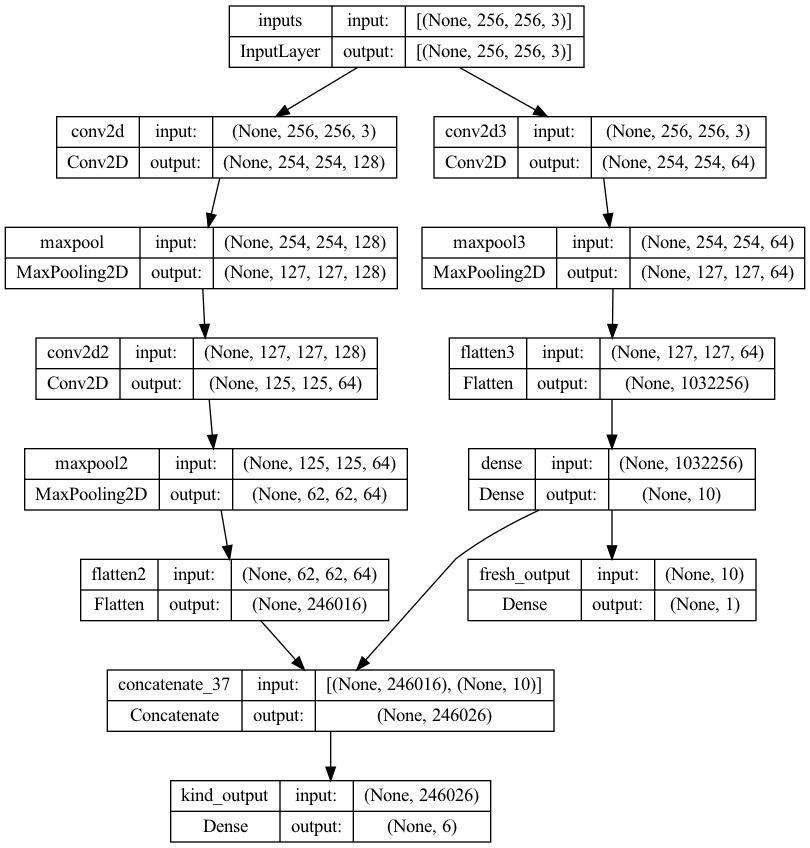

In [496]:
# 모델 살펴보기
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# 컴파일

In [497]:
# 하이퍼 파라미터

from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax
from keras.metrics import RootMeanSquaredError

optimizer = Adam(learning_rate = 0.001)

fresh_loss = 'binary_crossentropy'
kind_loss = 'sparse_categorical_crossentropy'
metrics = ['acc']

In [498]:
model.compile(optimizer = optimizer,
              loss = {'fresh_output' : fresh_loss, 'kind_output' : kind_loss},
              metrics = metrics)

# 학습

In [499]:
# 하이퍼 파라미터

epochs = 50
batch_size = 16
spe = len(x_train)/batch_size if len(x_train)%batch_size == 0 else len(x_train)/batch_size + 1

In [500]:
# resize 사용
history = model.fit({'inputs' : np.array(image_prep.img_resize_and_array(x_train))},
                    {'fresh_output' : np.array(y_train_fresh),
                     'kind_output' : np.array(y_train_kind)},
                    validation_data = ({'inputs' : np.array(image_prep.img_resize_and_array(x_val))},
                                       {'fresh_output' : np.array(y_val_fresh), 'kind_output' : np.array(y_val_kind)}),
                    epochs = epochs,)

Epoch 1/50
41/41 [==============================] - 73s 2s/step - loss: 2.7611 - fresh_output_loss: 1.7007 - kind_output_loss: 1.0604 - fresh_output_acc: 0.5514 - kind_output_acc: 0.6458 - val_loss: 1.8406 - val_fresh_output_loss: 1.3548 - val_kind_output_loss: 0.4858 - val_fresh_output_acc: 0.4259 - val_kind_output_acc: 0.8395
Epoch 2/50
41/41 [==============================] - 74s 2s/step - loss: 0.7359 - fresh_output_loss: 0.3810 - kind_output_loss: 0.3548 - fresh_output_acc: 0.5514 - kind_output_acc: 0.8755 - val_loss: 2.4926 - val_fresh_output_loss: 2.0864 - val_kind_output_loss: 0.4062 - val_fresh_output_acc: 0.4259 - val_kind_output_acc: 0.8302
Epoch 3/50
41/41 [==============================] - 77s 2s/step - loss: 0.5403 - fresh_output_loss: 0.2931 - kind_output_loss: 0.2472 - fresh_output_acc: 0.5514 - kind_output_acc: 0.9103 - val_loss: 2.5780 - val_fresh_output_loss: 2.2946 - val_kind_output_loss: 0.2834 - val_fresh_output_acc: 0.4259 - val_kind_output_acc: 0.9012
Epoch 4/50

# Score

<center>차수</center>

|차수|이미지사이즈|dt_split|epochs|최고모델|fresh_acc|kind_acc|비고|
|--|--|--|--|--|--|--|--|
|1차|112x112|0.56:0.14:0.3|50|CNN_1|4323|2707|데이터 부족으로 최고, 최저점 차이 큼|
|2차|112x112|0.56:0.14:0.3|50|CNN_1|4279|9258|운좋게 데이터셋 잘 분류된 것으로 보임|
|3차|112x112|0.8:0.2:0.01|50|CNN_1|4630|3241|데이터 부족으로 최고, 최저점 차이 큼|
|4차|112x112|0.8:0.2:0.01|50|CNN_1|4259|9290|운좋게 데이터셋 잘 분류된 것으로 보임|
|5차|112x112|0.8:0.2:0.01|50|CNN_1|4259|9321|조금의 성능 상승이 있으나.. 양질 데이터 대량 필요|
|6차|256x256|0.8:0.2:0.01|50|CNN_1|4259|9136|3600s|


<center>Dense</center>

|차수|모델|1층|유닛수|활성화 함수|2층|유닛수|활성화 함수|3층|유닛수|활성화 함수|출력층|활성화 함수|점수|fresh_acc|kind_acc|time(s)|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|2183|2707|150s|
|2차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|2183|7686|150s|
|3차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|1420|2623|150s|
|4차|Sequential_2|Dense|(256, 1024)|(relu, relu)|Dense|(128,128)|(relu, relu)|NA|NA|NA|Dense|(sigmoid,sigmoid)|점수|1667|7315|150s|


<center>CNN</center>

|차수|모델|1층|배치사이즈|활성화 함수|2층|배치사이즈|활성화 함수|3층|배치사이즈|활성화 함수|출력층|활성화 함수|점수|fresh_acc|kind_acc|time(s)|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4323|2707|150s|
|2차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4279|9258|150s|
|3차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4630|3241|210s|
|4차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|NA|NA|NA|Dense|(softmax,sigmoid)|점수|4259|9290|210s|
|5차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수|4259|9290|210s|
|5차|CNN_1|Conv2D|128|relu|MaxPool2D|NA|NA|(Conv2D, Dense)|(64,10)|relu|Dense|(softmax,sigmoid)|점수|4259|9136|3600s|

# test